## 전체 과정
1. 데이터 불러오기
    * booking_status의 값을 0, 1로 mapping하여 불러오기
    * 쪼개기 등
2. Feature Engineering
    * object을 categorical로 변환
    * 원한 인코딩
    * 정규화
3. 전체 attr간의 상관관계 분석
4. attr 선별
    * 상관없는 attr은 drop
5. 모델 선택하기
    * 모든 모델에 대해 hyper-parameter 수정해가며 최상위 모델 찾기
6. 모델 선택하기


## 1. 데이터 불러오기

In [1]:
# 필요한 모듈 import
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# train, test 데이터 가져오기
# booking_status는 0, 1로 바꾸어 가져오기
train = pd.read_csv('./train.csv')
train["booking_status"] = train["booking_status"].replace({'Canceled':1, 'Not_Canceled':0})

test = pd.read_csv('./test.csv')
train.head()

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN29581             2               0                     1   
1   INN06326             2               0                     1   
2   INN33900             2               0                     1   
3   INN00721             2               0                     2   
4   INN22121             2               1                     0   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  3       Meal Plan 1                           0   
1                  3       Meal Plan 1                           0   
2                  4       Meal Plan 1                           0   
3                  0       Meal Plan 1                           0   
4                  4       Meal Plan 1                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        200          2018              8            29   
1        Room_Type 1         79          2018              3            24   
2        Room_Type 4         78          2018              4             6   
3        Room_Type 1         61          2017             10             4   
4        Room_Type 1        201          2018             11             1   

  market_segment_type  repeated_guest  no_of_previous_cancellations  \
0              Online               0                             0   
1              Online               0                             0   
2              Online               0                             0   
3             Offline               0                             0   
4              Online               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               90.95   
1                                     0               90.95   
2                                     0               99.45   
3                                     0               91.00   
4                                     0               82.28   

   no_of_special_requests  booking_status  
0                       0               1  
1                       1               1  
2                       1               0  
3                       0               0  
4                       3               0

In [3]:
# train data, test data 형태 확인
train.shape, test.shape

((25392, 19), (10883, 18))

In [4]:
# 각 feature의 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25392 entries, 0 to 25391
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            25392 non-null  object 
 1   no_of_adults                          25392 non-null  int64  
 2   no_of_children                        25392 non-null  int64  
 3   no_of_weekend_nights                  25392 non-null  int64  
 4   no_of_week_nights                     25392 non-null  int64  
 5   type_of_meal_plan                     25392 non-null  object 
 6   required_car_parking_space            25392 non-null  int64  
 7   room_type_reserved                    25392 non-null  object 
 8   lead_time                             25392 non-null  int64  
 9   arrival_year                          25392 non-null  int64  
 10  arrival_month                         25392 non-null  int64  
 11  arrival_date   

In [5]:
# null 항목을 가진 attr을 우선 확인
# 없으므로 pass
train.isnull().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

## 2. Feature Engineering
1. Object to categegorical
    * Booking_ID는 나중에 제거하여 모델을 돌릴 것임
    * 1) type_of_meal_plan
    * 2) room_type_reserved
    * 3) market_segment_type

In [6]:
# seaborn을 통해 시각화하기
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()     # setting seaborn default for plots

In [7]:
# train과 test set를 합침
train_test_data = [train, test]

### 1-1) type_of_meal_plan

In [8]:
train['type_of_meal_plan'].value_counts()

Meal Plan 1     19492
Not Selected     3560
Meal Plan 2      2338
Meal Plan 3         2
Name: type_of_meal_plan, dtype: int64

### 1-2) room_type_reserved

In [9]:
train['room_type_reserved'].value_counts()

Room_Type 1    19684
Room_Type 4     4242
Room_Type 6      667
Room_Type 2      498
Room_Type 5      186
Room_Type 7      111
Room_Type 3        4
Name: room_type_reserved, dtype: int64

<AxesSubplot:>

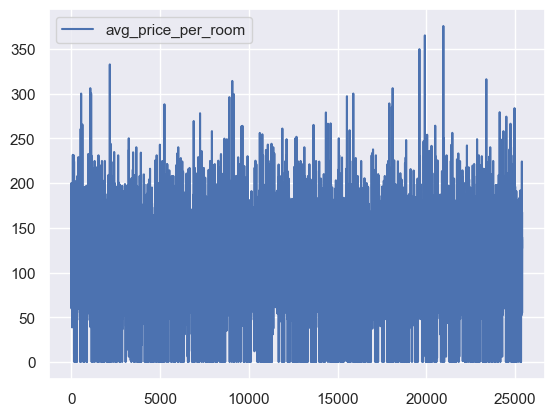

In [10]:
# room_type_reserved과 avg_price_per_room과의 관계

df1 = train[['avg_price_per_room', 'room_type_reserved']]
df1.plot()

In [11]:
# room_type_reserved
roomtype_mapping = {
    "Room_Type 1": 0, "Room_Type 4": 1, 'Other': 0
}

for dataset in train_test_data:
    dataset['room_type_reserved'] = dataset['room_type_reserved'].map(roomtype_mapping)

### 1-3) market_segment_time
* Online: 0
* Offline: 1

In [12]:
train['market_segment_type'].value_counts()

Online           16210
Offline           7398
Corporate         1427
Complementary      272
Aviation            85
Name: market_segment_type, dtype: int64

In [13]:
# Corporate 회사? -> online

market_mapping = {
    "Online": 0, "Offline": 1, "Corporate": 2, "Complementary": 2, "Aviation": 2
}

for dataset in train_test_data:
    dataset['market_segment_type'] = dataset['market_segment_type'].map(market_mapping)

In [14]:
train.head()

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN29581             2               0                     1   
1   INN06326             2               0                     1   
2   INN33900             2               0                     1   
3   INN00721             2               0                     2   
4   INN22121             2               1                     0   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  3       Meal Plan 1                           0   
1                  3       Meal Plan 1                           0   
2                  4       Meal Plan 1                           0   
3                  0       Meal Plan 1                           0   
4                  4       Meal Plan 1                           0   

   room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0                 0.0        200          2018              8            29   
1                 0.0         79          2018              3            24   
2                 1.0         78          2018              4             6   
3                 0.0         61          2017             10             4   
4                 0.0        201          2018             11             1   

   market_segment_type  repeated_guest  no_of_previous_cancellations  \
0                    0               0                             0   
1                    0               0                             0   
2                    0               0                             0   
3                    1               0                             0   
4                    0               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               90.95   
1                                     0               90.95   
2                                     0               99.45   
3                                     0               91.00   
4                                     0               82.28   

   no_of_special_requests  booking_status  
0                       0               1  
1                       1               1  
2                       1               0  
3                       0               0  
4                       3               0

## 3. 전체 attr간의 상관관계 분석

#### seaborn으로 속성 간 상관관계 확인

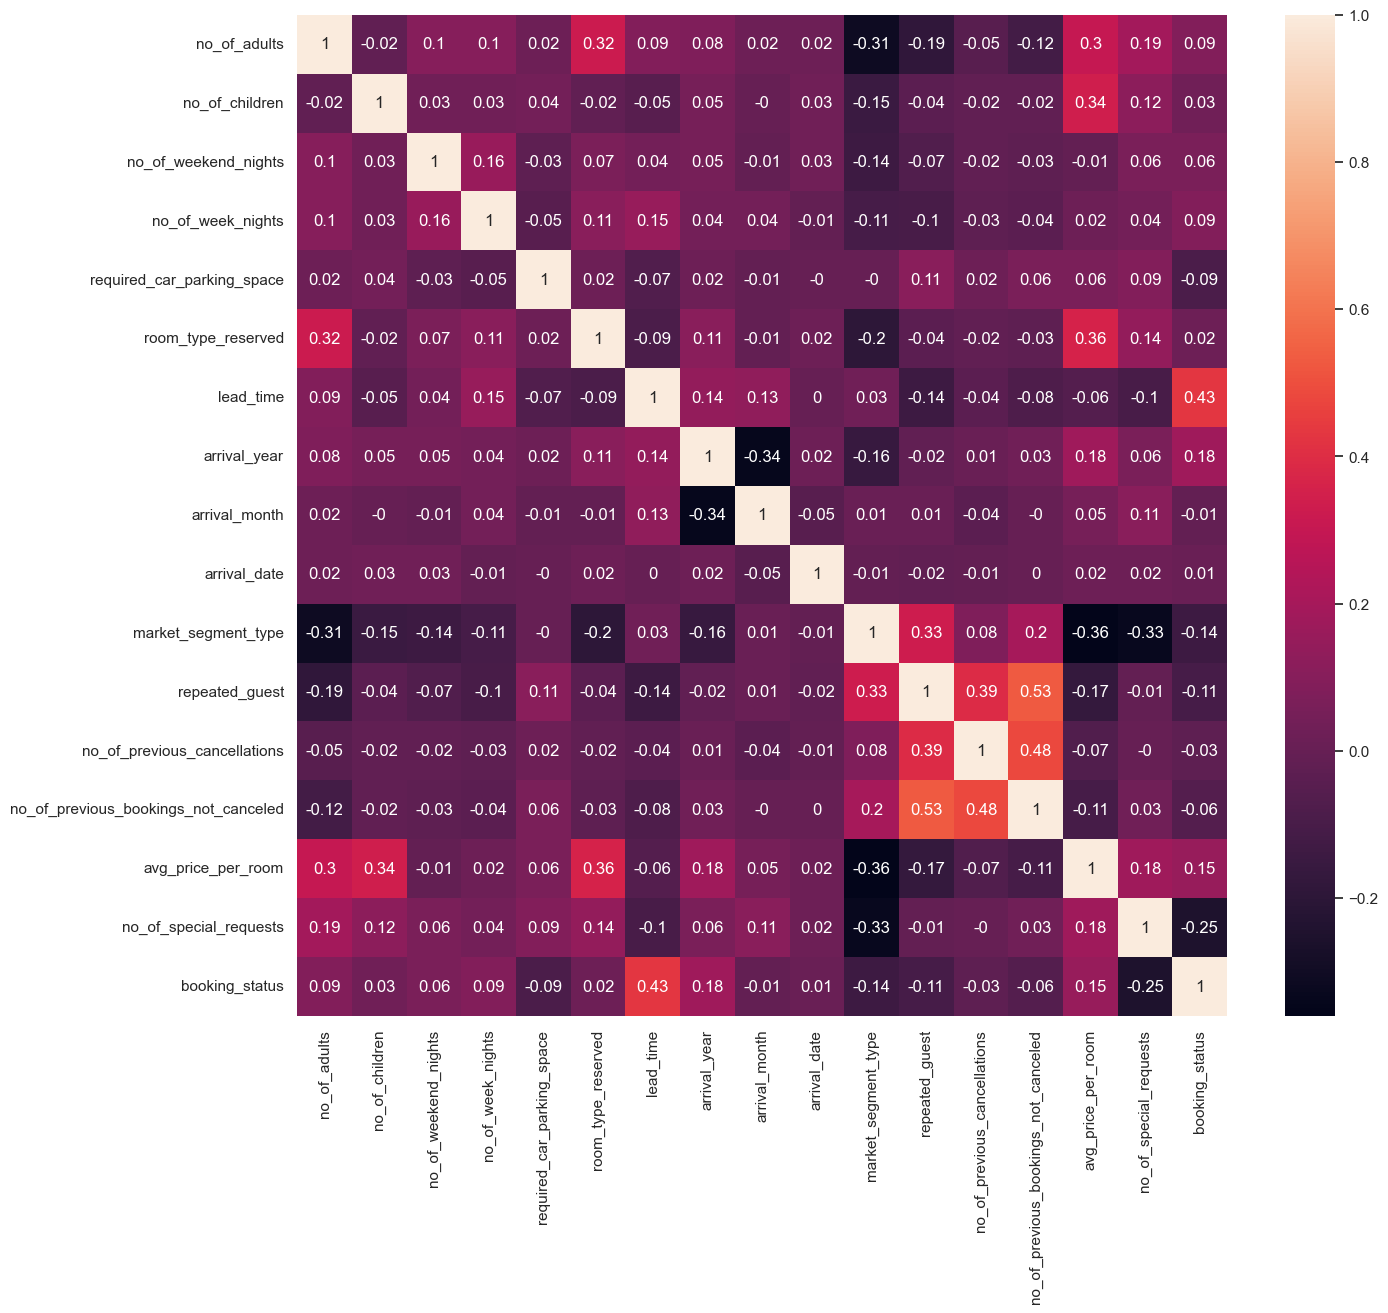

In [15]:
sns.set(rc={'figure.figsize':(15,13)}) 
correlation_matrix = train.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True) 
plt.show()

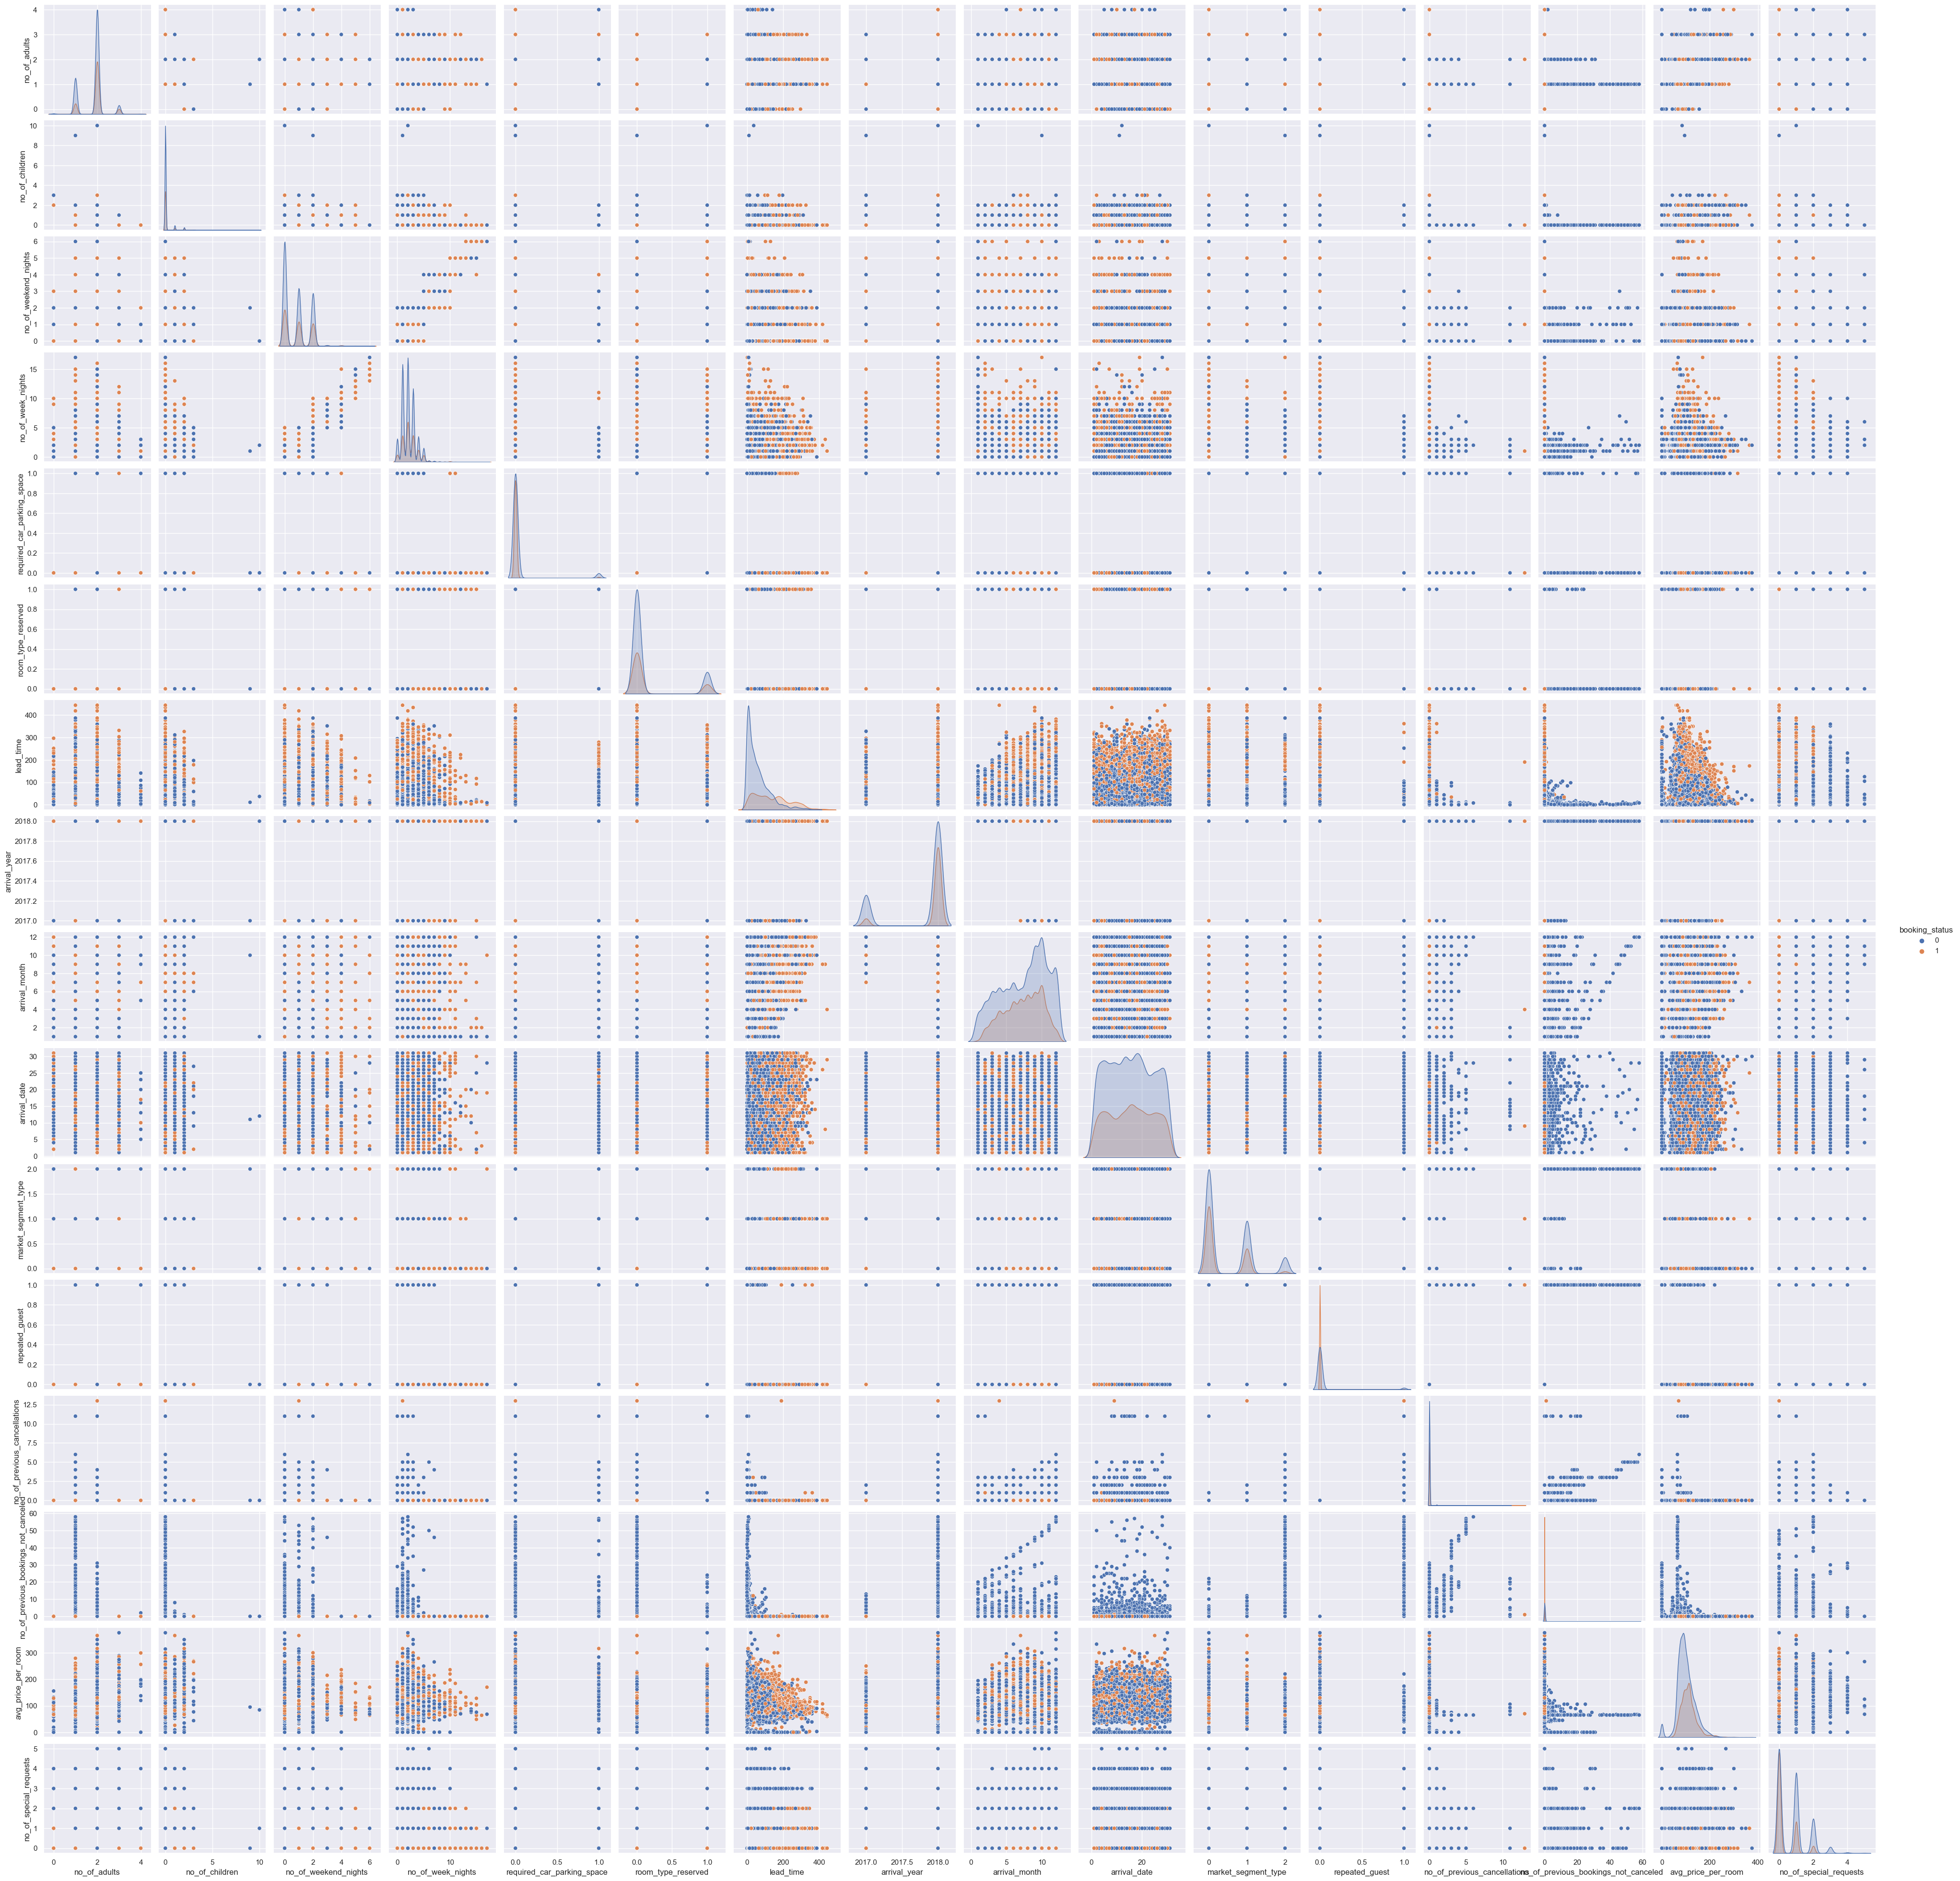

In [93]:
sns.pairplot(train, hue='booking_status')

booking_status와 상관관계가 가장 높은 속성 선택
1. lead_time: 0.43
2. no_of_special_requests: -0.25
3. arrival_year: 0.18
4. avg_price_per_room: 0.15
5. market_segment_type: -0.14
6. repeated_guest: -0.11
7. no_of_adults: 0.09, no_of_week_nights: 0.09, required_car_parking_space: -0.09

## 4. attr 선별(1)
필요없는 attr은 제거할것

#### 4-1) 첫 번째 feature 선택 (상위 5개 features)
booking_status와 상관관계가 가장 높은 features중 상위 5개 선택

In [16]:
features_drop = [
    'Booking_ID',
    # 'no_of_adults',
    'no_of_children',
    'no_of_weekend_nights',
    # 'no_of_week_nights',
    'type_of_meal_plan',
    # 'required_car_parking_space',
    'room_type_reserved',
    # 'lead_time',
    # 'arrival_year',
    'arrival_month',
    'arrival_date',
    # 'market_segment_type',
    'repeated_guest',
    'no_of_previous_cancellations',
    'no_of_previous_bookings_not_canceled',
    # 'avg_price_per_room',
    # 'no_of_special_requests'
]

In [17]:
train_set1 = train.drop(features_drop, axis=1)      # 뺄 feature는 뺀 train_set
# print(train_set1.shape)

train_data = train_set1.drop(['booking_status'], axis=1)
target = train['booking_status']

train_data.shape, target.shape

((25392, 8), (25392,))

In [18]:
train_data.head()

no_of_adults  no_of_week_nights  required_car_parking_space  lead_time  \
0             2                  3                           0        200   
1             2                  3                           0         79   
2             2                  4                           0         78   
3             2                  0                           0         61   
4             2                  4                           0        201   

   arrival_year  market_segment_type  avg_price_per_room  \
0          2018                    0               90.95   
1          2018                    0               90.95   
2          2018                    0               99.45   
3          2017                    1               91.00   
4          2018                    0               82.28   

   no_of_special_requests  
0                       0  
1                       1  
2                       1  
3                       0  
4                       3

## 5. 모델 선택하기

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

### 5-1) kNN

In [20]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [23]:
clf_knn = KNeighborsClassifier(n_neighbors=5)    # 13개의 이웃
scoring = 'accuracy'
score = cross_val_score(clf_knn, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

/Users/min02choi/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/min02choi/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

[0.81811024 0.81062992 0.81488775 0.80661678 0.79716424 0.81213076
 0.8117369  0.80897991 0.80307208 0.79401339]


/Users/min02choi/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/min02choi/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

In [24]:
# kNN score
round(np.mean(score) * 100, 2)

80.77

### 5-2) Decision Tree

In [25]:
clf_tree1 = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=18,
    min_samples_split=15,
    min_samples_leaf=3,
    max_features=4,
    # random_state=1
)
scoring = 'accuracy'
score = cross_val_score(clf_tree1, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.86771654 0.85590551 0.87002757 0.85584876 0.86096889 0.86608901
 0.85348562 0.86293816 0.8617566  0.85466719]


In [26]:
# Decision Tree score
round(np.mean(score) * 100, 2)

86.09

In [27]:
x_test = test.drop(features_drop, axis=1)
x_test.shape

(10883, 8)

In [28]:
clf_tree1.fit(train_data, target)
prediction_list = clf_tree1.predict(x_test)

submit = pd.read_csv("./sample_submission.csv")
submit["booking_status"] = prediction_list
submit = submit.replace({'Canceled':1, 'Not_Canceled':0})
submit

Booking_ID  booking_status
0       INN04969               0
1       INN34541               0
2       INN36109               0
3       INN01554               1
4       INN24975               0
...          ...             ...
10878   INN29686               0
10879   INN01107               1
10880   INN06811               0
10881   INN27777               1
10882   INN04027               1

[10883 rows x 2 columns]

In [29]:
submit.to_csv("dt_submit.csv",index=False)

## 4. attr선별(2)

In [40]:
# 다른 attr과 상관계수가 낮은 required_car_parking_space 선택
# required_car_parking_space > no_of_weekend_nights > no_of_adults

# 근데 이 선택방법이 맞는건지 잘 모르겠다

features_drop2 = [
    'Booking_ID',
    # 'no_of_adults',
    'no_of_children',
    'no_of_weekend_nights',
    # 'no_of_week_nights',
    'type_of_meal_plan',
    # 'required_car_parking_space',
    'room_type_reserved',
    # 'lead_time',
    # 'arrival_year',
    'arrival_month',
    'arrival_date',
    # 'market_segment_type',
    # 'repeated_guest',
    'no_of_previous_cancellations',
    'no_of_previous_bookings_not_canceled',
    # 'avg_price_per_room',
    # 'no_of_special_requests'
]

In [41]:
train_set2 = train.drop(features_drop2, axis=1)      # 뺄 feature는 뺀 train_set
# print(train_set1.shape)

train_data2 = train_set2.drop(['booking_status'], axis=1)
target = train['booking_status']

train_data2.shape, target.shape

((25392, 9), (25392,))

In [42]:
train_data2.head()

no_of_adults  no_of_week_nights  required_car_parking_space  lead_time  \
0             2                  3                           0        200   
1             2                  3                           0         79   
2             2                  4                           0         78   
3             2                  0                           0         61   
4             2                  4                           0        201   

   arrival_year  market_segment_type  repeated_guest  avg_price_per_room  \
0          2018                    0               0               90.95   
1          2018                    0               0               90.95   
2          2018                    0               0               99.45   
3          2017                    1               0               91.00   
4          2018                    0               0               82.28   

   no_of_special_requests  
0                       0  
1                       1  
2                       1  
3                       0  
4                       3

## 5. model 선택

In [61]:
clf_tree2 = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=20,
    min_samples_split=7,
    min_samples_leaf=3,
    max_features=4,
    # random_state=1
)
scoring = 'accuracy'
score = cross_val_score(clf_tree2, train_data2, target, cv=k_fold, n_jobs=2, scoring=scoring)
print(score)

[0.86850394 0.8488189  0.86490744 0.85230406 0.86096889 0.86923986
 0.85230406 0.85387948 0.86333202 0.85939346]


In [62]:
# Decision Tree score
round(np.mean(score) * 100, 2)

85.94

In [268]:
x_test = test.drop(features_drop2, axis=1)
x_test.shape

(10883, 7)

In [269]:
clf_tree2.fit(train_data2, target)
prediction_list = clf_tree2.predict(x_test)

submit = pd.read_csv("./sample_submission.csv")
submit["booking_status"] = prediction_list
submit = submit.replace({'Canceled':1, 'Not_Canceled':0})
submit

Booking_ID  booking_status
0       INN04969               0
1       INN34541               0
2       INN36109               0
3       INN01554               0
4       INN24975               0
...          ...             ...
10878   INN29686               0
10879   INN01107               1
10880   INN06811               0
10881   INN27777               1
10882   INN04027               1

[10883 rows x 2 columns]

In [270]:
submit.to_csv("dt_submit.csv",index=False)